# Detecting Mussel Farms using Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Introduction" data-toc-modified-id="Introduction">Introduction</a></span></li>
    <li><span><a href="#Export training data" data-toc-modified-id="Export training data">Export training data</a></span>
    <li><span><a href="#Train the model" data-toc-modified-id="Train the model">Train the model</a></span>
        <ul class="toc-item">
            <li><span><a href="#Necessary imports" data-toc-modified-id="Necessary imports">Necessary imports</a></span></li>
            <li><span><a href="#Get training data" data-toc-modified-id="Get training data">Get training data</a></span></li>
            <li><span><a href="#Prepare data" data-toc-modified-id="Prepare data">Prepare data</a></span></li>
            <li><span><a href="#Visualize training data" data-toc-modified-id="Visualize training data">Visualize training data</a></span></li>
            <li><span><a href="#Load model architecture" data-toc-modified-id="Load model architecture">Load model architecture</a></span></li>
            <li><span><a href="#Find an optimal learning rate" data-toc-modified-id="Find an optimal learning rate">Find an optimal learning rate</a></span></li>
            <li><span><a href="#Fit the model" data-toc-modified-id="Fit the model">Fit the model</a></span></li>
            <li><span><a href="#Visualize results in validation set" data-toc-modified-id="Visualize results in validation set">Visualize results in validation set</a></span></li>
            <li><span><a href="#Accuracy assessment" data-toc-modified-id="Accuracy assessment">Accuracy assessment</a></span></li>
            <li><span><a href="#Save the model" data-toc-modified-id="Save the model">Save the model</a></span></li></ul></li>
    <li><span><a href="#Deploy the model and detect mussel farms" data-toc-modified-id="Deploy model and detect mussel farms">Deploy model and detect mussel farms</a></span>
        <ul class="toc-item">
            <li><span><a href="#Model Builder" data-toc-modified-id="Model Builder">Model Builder</a></span></li>
            <li><span><a href="#Results" data-toc-modified-id="Results">Model inference</a></span></li></ul></li>
    <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

## Introduction

Mussels are aquatic animals with bivalved hard shells that are consumed by millions of people around the world. Mussels grow in fresh water rivers or lakes near their openings to saline waters of the ocean, as well as in some coastal intertidal regions. Mussel aquaculture involves floating rafts that have ropes suspended in the water on which the mussels are cultured. The farmers collect mussel seeds from nearby rocky shores during low tides and attach them to the ropes in their rafts. Later, these ropes are covered with mesh socks that collect the mussels once they are ripe.

<figure>    
   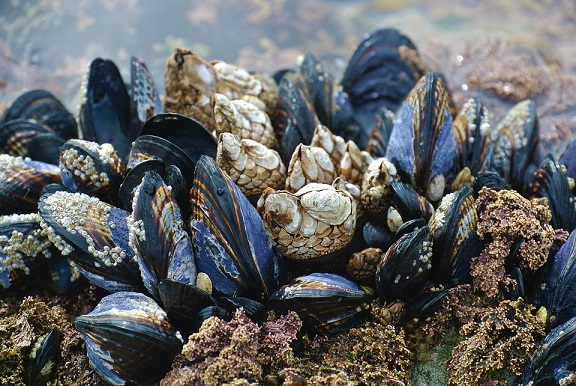
    <br>
    <center>
    <figcaption>Mussels growing on a rocky shore </figcaption>
    </center>
</figure>

Spain is one of the biggest producer of mussels in the world. The Galicia region in Spain accounts for almost 90 percent of the mussel aquaculture in the country. Our study area for this notebook is Ria de Arousa, which is the biggest mussel farming area in Galicia region.

<figure>    
   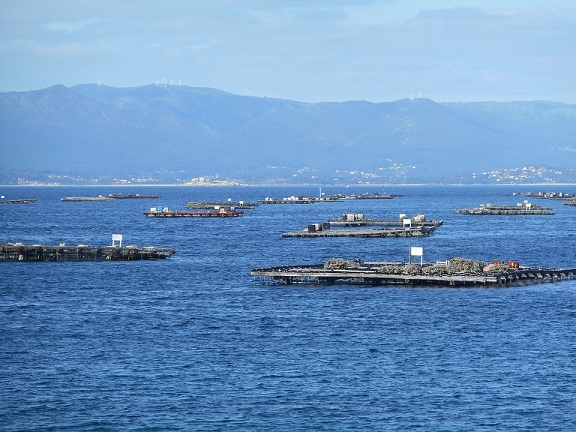
    <br>
    <center>
    <figcaption>Mussel Farms in Ria de Arousa, Spain </figcaption>
    </center>
</figure>

Monitoring of such aquacultures is an important aspect of maintaining the aquatic ecosystems. While sustainable farming can help the ecosystem, it's exploitation can degrade the environment quality and biodiversity. Therefore, it is important to monitor the growth of mussel farms in a region and their expansion into fragile areas. While physical surveys can be arduous and time consuming, satellite imagery and deep learning can help in monitoring mussel farming with much less effort. These analysis can also be helpful in comparing changes over longer periods of time.

In this notebook, we will train a deep learning model to detect mussel farms in high-resolution imagery of the Ria De Arousa region of Spain.

## Export training data

In [10]:
# Connect to GIS
from arcgis.gis import GIS
gis = GIS("home")

The following imagery layer contains high resolution imagery of a part of the Ria De Arousa region. The spatial resolution of the imagery is 30 cm, and it contains 3 bands: Red, Green, and Blue. It is used as the 'Input Raster' for exporting the training data.

<Item title:"mussel_farm_training_imagery" type:Imagery Layer owner:demos_deldev>
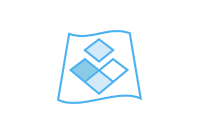

In [2]:
training_raster = gis.content.get('f2b92eed10394e5eb3c7f135861937d9')
training_raster

The following feature layer contains the bounding boxes for a few mussel farms in the Ria de Arousa region. It is used as the 'Input Feature Class' for exporting the training data.

<Item title:"MusselFarms" type:Feature Layer Collection owner:api_data_owner>
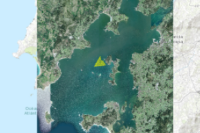

In [3]:
training_feature_layer = gis.content.get('ff6a48b3391c4a24b807af0eb08bb6c1')
training_feature_layer

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm). For this example, we prepared the training data in the 'PASCAL Visual Object Classes' format, using a 'chip_size' of 448px and a 'cell_size' of 0.3m, in ArcGIS Pro. The 'Input Raster' and the 'Input Feature Class' have been made available to export the required training data. We have also provided the exported training data in the next section, if you wish to skip this step.

<figure>    
   <img src='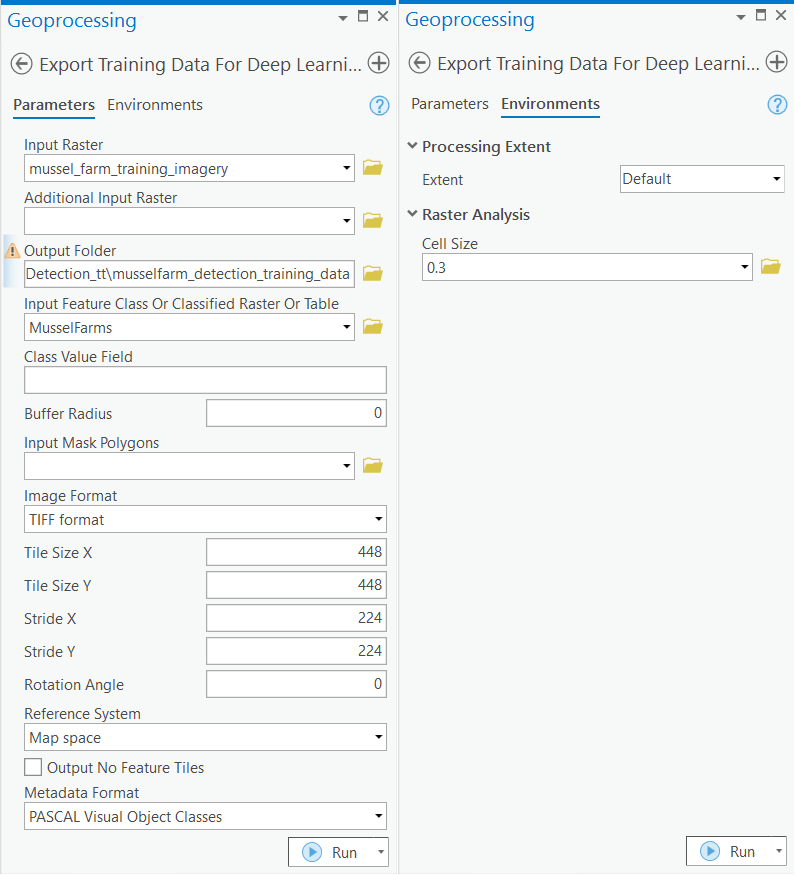 '>
    <br>
    <center>
    <figcaption>Export Training Data for Deep Learning </figcaption>
    </center>
</figure> 

## Train the model

### Necessary imports

In [1]:
import os
import glob
import zipfile
from pathlib import Path
from arcgis.learn import prepare_data, MMDetection

### Get training data

We have already exported the data that can be directly used by following the steps below:

<Item title:"musselfarm_detection_training_data" type:Image Collection owner:api_data_owner>
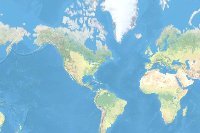

In [7]:
training_data = gis.content.get('57cb821dedca4c5598e81c8d2d510c91')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data

We will specify the path to our training data and a few hyperparameters. 

- `path`: path of the folder/list of folders containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch. Depends on the memory of your graphic card.
- `chip_size`: The same as the tile size used while exporting the dataset.

In [4]:
data = prepare_data(path, batch_size=4, chip_size=448)

### Visualize training data

To get a sense of what the training data looks like, the `show_batch()` method will randomly pick a few training chips and visualize them.

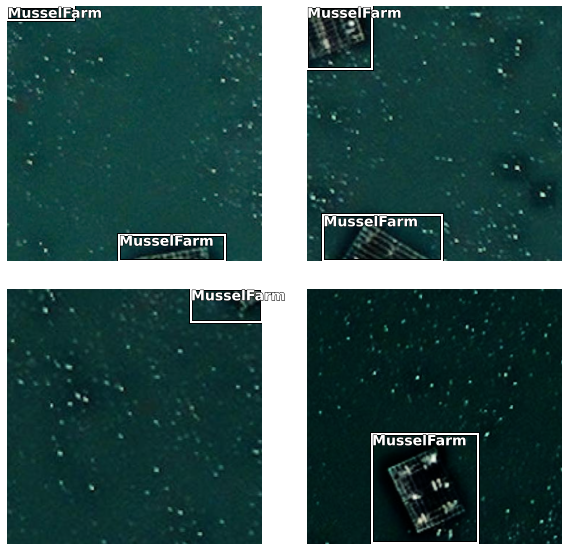

In [7]:
data.show_batch(rows=2)

### Load model architecture

Through the integration of the MMDetection library, `arcgis.learn` allows the use of the Dynamic RCNN model, along with many other models. For more in-depth information on how to use MMDetection, please see [Use MMDetection with arcgis.learn](https://developers.arcgis.com/python/guide/use-mmdetection-with-arcgis-learn/).

In [28]:
MMDetection.supported_models

['atss',
 'carafe',
 'cascade_rcnn',
 'cascade_rpn',
 'dcn',
 'detectors',
 'double_heads',
 'dynamic_rcnn',
 'empirical_attention',
 'fcos',
 'foveabox',
 'fsaf',
 'ghm',
 'hrnet',
 'libra_rcnn',
 'nas_fcos',
 'pafpn',
 'pisa',
 'regnet',
 'reppoints',
 'res2net',
 'sabl',
 'vfnet']

In [8]:
model = MMDetection(data, 'dynamic_rcnn')

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. The ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

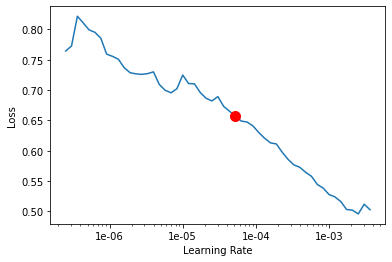

5.248074602497728e-05

In [5]:
lr = model.lr_find()
lr

### Fit the model 

Next, we will train the model for a few epochs with the learning rate found above. Given the small size of the training dataset, we can train the model for 10 epochs.

In [9]:
model.fit(10, lr=lr)

epoch,train_loss,valid_loss,time
0,0.470889,0.450983,02:34
1,0.394933,0.357216,02:23
2,0.343201,0.337205,02:23
3,0.328651,0.334981,02:24
4,0.328875,0.333780,02:23
5,0.298451,0.316607,02:24
6,0.271269,0.329459,02:22
7,0.291253,0.290861,02:21
8,0.252018,0.266310,02:21
9,0.268863,0.271536,02:20


As we can see, the training and validation losses were decreasing until the 9th epoch, before increasing slightly in the last epoch. As such, there could be room for more training.

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model we trained.

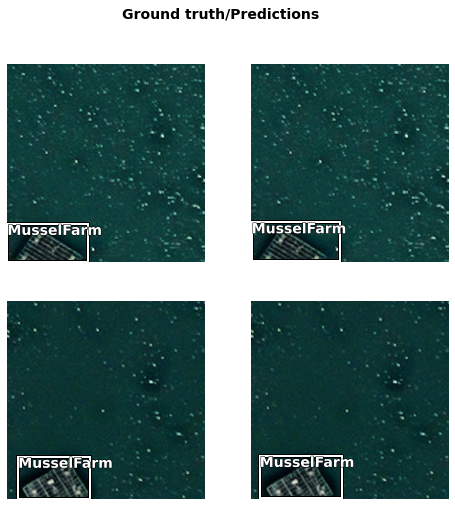

In [11]:
model.show_results()

### Accuracy assessment

`arcgis.learn` provides the `average_precision_score()` method that computes the average precision of the model on the validation set for each class.

In [12]:
model.average_precision_score()

{'MusselFarm': 0.8765481875716432}

### Save the model

We will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save('musselfarms_mmd_dynamic_rcnn_10ep')

## Deploy the model and detect mussel farms

We can now use the saved model to detect mussel farms in the entire Ria De Arousa region. Here, we have provided only a sample raster for Ria De Arousa. The following imagery layer contains high resolution imagery of a part of the Ria De Arousa region. The spatial resolution of the imagery is 30 cm and contains 3 bands: Red, Green, and Blue.

<Item title:"mussel_farm_detection_test_imagery" type:Imagery Layer owner:demos_deldev>
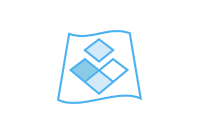

In [11]:
sample_inference_raster = gis.content.get('d6f035f5de504c86855e0ee70e83ad0e')
sample_inference_raster

### Model Builder

To save time and resources, we will only run the model on the water body and not the surrounding land masses, as the mussel farms are only found in water. To extract a raster with only the water body, we created a water mask using the Sentinel-2 Views NDWI. The following model builder can be used to create a water mask and detect the mussel farms.

<Item title:"Model Builder for Mussel Farm Detection" type:Geoprocessing Sample owner:api_data_owner>
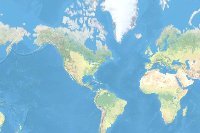

In [4]:
model_builder = gis.content.get('2647a386f5a04917b74cc4f40a48f57f')
model_builder

Tools used:
- Copy Raster: Copies a region of the [Sentinel-2 Views NDWI](https://www.arcgis.com/home/item.html?id=112db40d3640473aacb0d1f891462496) hosted imagery and creates a subset to be processed further.
- Greater Than Equal: Creates a binary raster with water pixels as 1 and others as 0.
- Reclassify: Reclassifies the other pixels (value 0) in the binary raster as 'No Data'.
- Raster to Polygon: Converts the raster into a feature layer with polygons representing the water mask.
- Fill Gaps: Fills gaps smaller than 1500 square meters (approximate maximum area of a mussel farm) in the water mask.
- Extract By Mask: Uses the water mask to clip the original raster and create a new raster containing only the water body.
- Detect Objects Using Deep learning: Detects mussel farms on the clipped raster using the model we trained earlier.

<figure>    
   <img src=' 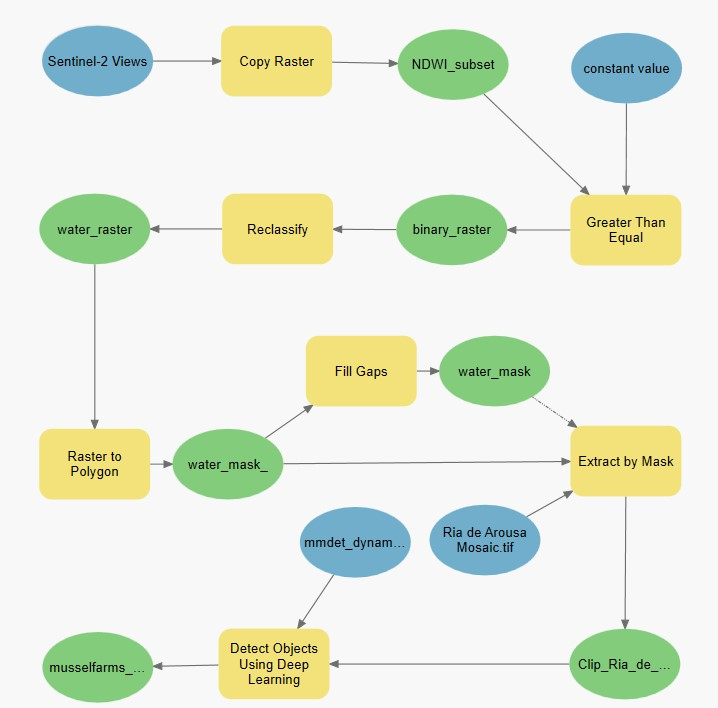'>
    <br>
    <center>
    <figcaption> Model Builder </figcaption>
    </center>
</figure> 

We can use the following step if we want to detect mussel farms in any given imagery containing only the water body, without running the model builder. In this step, we will generate a feature layer with detected mussel farms using the 'Detect Objects Using Deep Learning' tool available in both [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/enterprise/detect-objects-using-deep-learning.htm).

<figure>    
   <img src=' 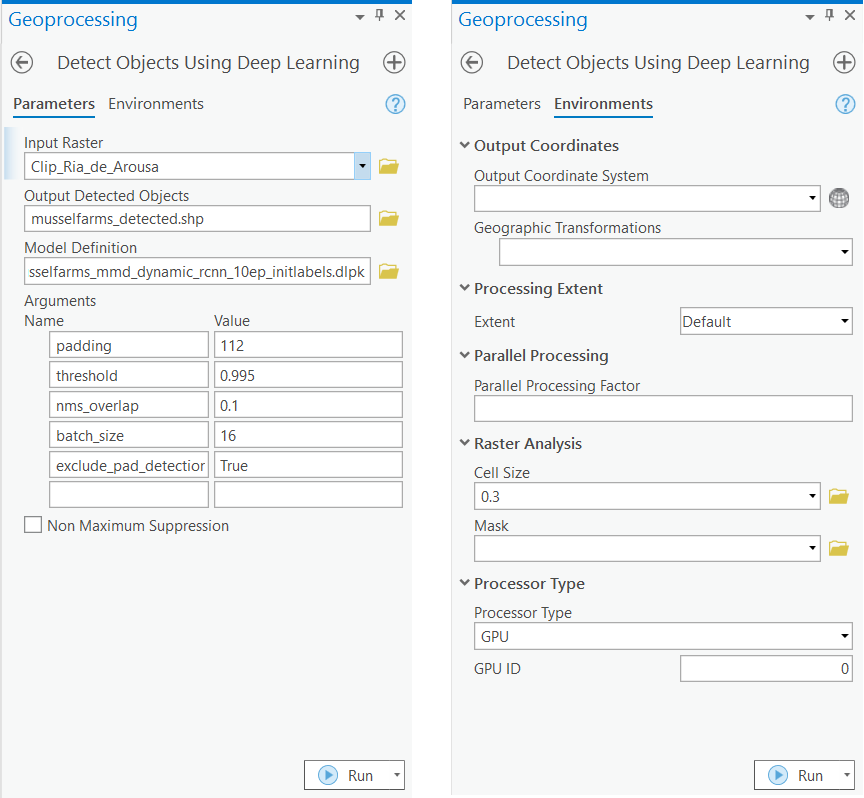 '>
    <br>
    <center>
    <figcaption>Detect Objects Using Deep Learning </figcaption>
    </center>
</figure>

### Results

The model was run on the entire Ria De Arousa region and the results can be viewed here.

In [6]:
fc = gis.content.get('477d756f79e4400fa91c5b220406d98c')
fc

<Item title:"musselfarms_detected" type:Feature Layer Collection owner:demos_deldev>

In [11]:
from arcgis.mapping import WebMap
wm_item = gis.content.get('36714d14f80649e99aaf702f3cec6455')

In [ ]:
wm = WebMap(wm_item)
wm.add_layer(fc)
wm

<figure>    
   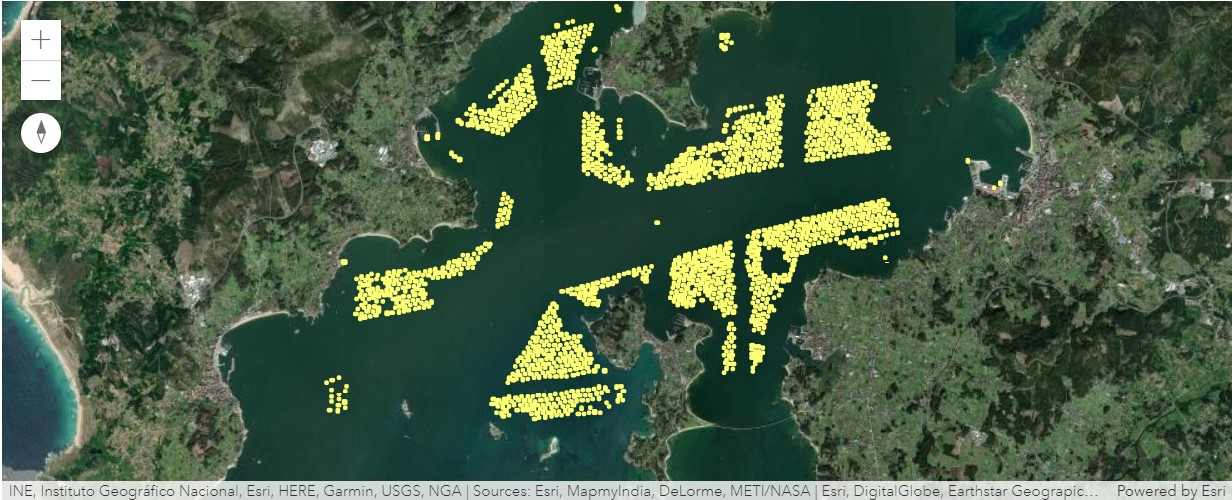
</figure> 

## Conclusion

In this notebook, we saw how we can use deep learning and high-resolution satellite imagery to detect mussel farms. This can be an important task for monitoring and conservation purposes. We used a small sample as training data with one of the object detection models available through the MMDetection integration in `arcgis.learn`. We trained the deep learning model for a few iterations and then deployed it to detect all the mussel farms in the Ria De Arousa region. To save time and resources we used a model builder that clipped out a raster containing only the water body. This clipped raster was used to detect the farms. The results are highly accurate and almost all the mussel farms in the region have been detected.